# Applying FDTD to Photonic Crystal Slab Simulation
In this lecture, we show how to apply FDTD to solve a slightly more complicated EM problem involving a photonic crystal slab that supports guided resonance.
- Explain the importance of setting up sufficient runtime in computing transmission spectrum, so that the field of the long-lived mode can decay to a negligible value.
- Show the long decay tail of the mode in the time domain, the transmission spectrum that exhibits Fano-resonant lineshape.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

In [2]:
runtime = 100.0 # in unit of 1/frequency bandwidth of the source
dPML = 1.0 # space between PhC slabs and PML, in unit of longest wavelength of interest

In [3]:
# Wavelength and frequency range
freq_range = (75e12, 135e12)
lambda_range = (td.constants.C_0/freq_range[1], td.constants.C_0/freq_range[0])
freq0 = np.sum(freq_range)/2

# central frequency, frequency pulse width
lambda0 = td.C_0 / freq0
width = 0.3
freqw  = width * (freq_range[1] - freq_range[0])

# runtime
t_stop = runtime/freqw
print(f"Total runtime <= {t_stop*1e12} ps")

# frequencies and wavelengths of monitor
Nfreq = 1001
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# PhC slab
period = 1.0 # um, period along x- and y- direction
t_slab = 0.55 # um, thickness
ep_slab = 12 # permittivity
mat_slab = td.Medium(permittivity=ep_slab, name='silicon')

# PhC air hole
radius = 0.2 # um, radius
ep_hole = 1 #permittivity
mat_hole = td.Medium(permittivity=ep_hole, name='air')

# Grid size # um
dl = lambda_range[0] / 30 / np.sqrt(ep_slab) # 30 grids per smallest wavelength in medium
print(f"dl = {dl*1000} nm")

# space between PhC slabs and PML
spacing = dPML * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (period, period, 2*spacing + t_slab)

Total runtime <= 5.555555555555555 ps
dl = 21.368550163866615 nm


In [4]:
slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(td.inf,td.inf,t_slab),
    ),
    medium=mat_slab,
    name='slab',
)

hole = td.Structure(
    geometry=td.Cylinder(
        center=(0, 0, 0),
        axis=2,
        radius=radius,
        length=t_slab,
    ),
    medium=mat_hole,
    name='air hole',
)

In [5]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing/2),
    direction='+',
    pol_angle=0,
    name='planewave',
)

In [6]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='flux',
)

In [7]:
# We are interested in measuring the time evolution at a single point in the field monitor plane
monitor_time = td.FieldTimeMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (0, 0, 0),
    fields = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    name='time',
)

23:25:54 +07 WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

In [8]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab,hole],
    sources = [source],
    monitors = [monitor,monitor_time],
    run_time = t_stop,
    shutoff = 1e-7,
    boundary_spec = td.BoundarySpec.pml(z=True),
    normalize_index = None,
)

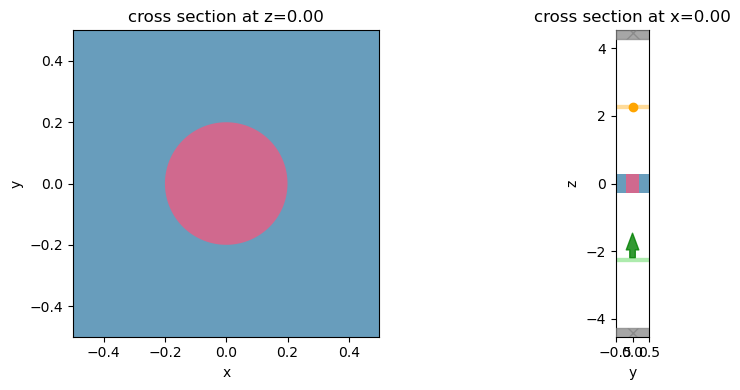

In [9]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim.plot(z=0., ax=ax[0]);
sim.plot(x=0, freq=freq0, ax=ax[1]);
plt.show()

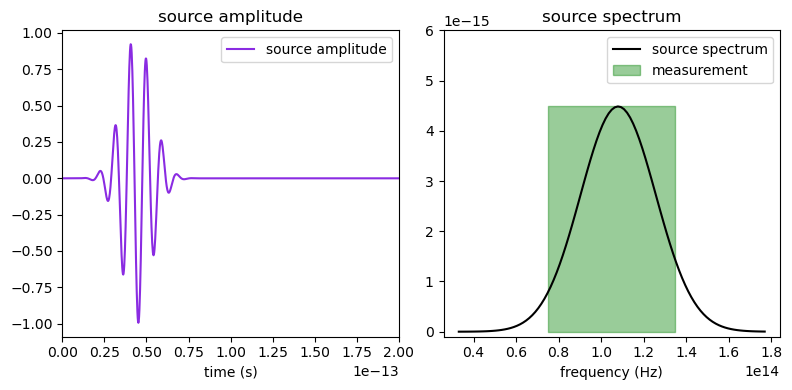

In [10]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = 0.2e-12
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, plot_time, 1001), ax=ax1)
ax1.set_xlim(0, plot_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 10001), val = 'abs', ax=ax2)
fill_max = 45e-16
ymax = 60e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [11]:
sim0 = sim.copy(update={'structures':[]})

In [12]:
sim_data0 = web.run(sim0, task_name='lecture03_PhC_normalization', path=f'data/data0_PhC_run{runtime}_PML{dPML}.hdf5')
sim_data = web.run(sim, task_name='lecture03_PhC_transmission', path=f'data/data_PhC_run{runtime}_PML{dPML}.hdf5')

23:26:24 +07 Created task 'lecture03_PhC_normalization' with task_id            
             'fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=218791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=199062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\taskId]8;;\]8;id=218791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\=]8;;\]8;id=278891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\fdve]8;;\]8;id=218791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\-69f0002c-c8f]8;;\
             ]8;id=218791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\f-4e57-ac89-75a488dc5f7b']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:26:27 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:26:32 +07 status = preprocess

23:26:34 +07 Maximum FlexCredit cost: 0.040. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

23:26:39 +07 early shutoff detected at 4%, exiting.

             status = postprocess

             status = success

             View simulation result at                                          
             ]8;id=318991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=121206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\taskId]8;;\]8;id=318991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\=]8;;\]8;id=432428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\fdve]8;;\]8;id=318991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\-69f0002c-c8f]8;;\
             ]8;id=318991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69f0002c-c8ff-4e57-ac89-75a488dc5f7b\f-4e57-ac89-75a488dc5f7b']8;;\.

23:26:42 +07 loading simulation from data/data0_PhC_run100.0_PML1.0.hdf5

             Created task 'lecture03_PhC_transmission' with task_id             
             'fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=442261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=38839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\taskId]8;;\]8;id=442261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\=]8;;\]8;id=121777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\fdve]8;;\]8;id=442261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\-ca9cb6ef-712]8;;\
             ]8;id=442261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\5-4deb-96a0-bdace5339f77']8;;\.

23:26:45 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:26:49 +07 status = preprocess

23:26:52 +07 Maximum FlexCredit cost: 0.040. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

23:26:53 +07 running solver

23:27:14 +07 status = postprocess

23:27:17 +07 status = success

             View simulation result at                                          
             ]8;id=424892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=916341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\taskId]8;;\]8;id=424892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\=]8;;\]8;id=11004;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\fdve]8;;\]8;id=424892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\-ca9cb6ef-712]8;;\
             ]8;id=424892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ca9cb6ef-7125-4deb-96a0-bdace5339f77\5-4deb-96a0-bdace5339f77']8;;\.

23:27:24 +07 loading simulation from data/data_PhC_run100.0_PML1.0.hdf5

             WARNING: Simulation final field decay value of 1.98e-07 is greater 
             than the simulation shutoff threshold of 1e-07. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

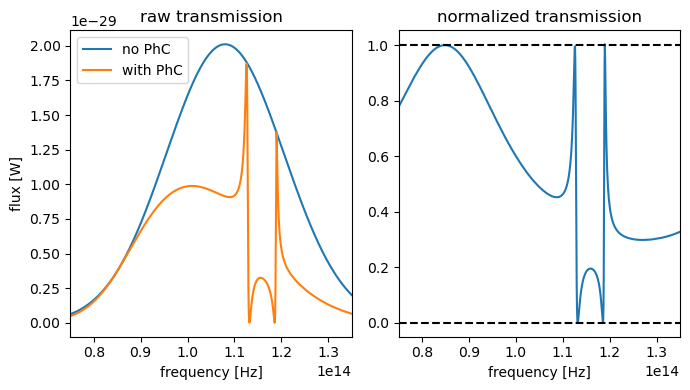

In [13]:
# Retrieve the power flux through the monitor plane.

transmission0 = sim_data0['flux'].flux
transmission = sim_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), tight_layout=True)
transmission0.plot(ax=ax1, label='no PhC')
transmission.plot(ax=ax1, label='with PhC')
ax1.set_xlim((freq_range[0],freq_range[1]))
transmission_normalized.plot(ax=ax2)
ax2.hlines(1.0,freq_range[0],freq_range[1],linestyles='dashed',color='black')
ax2.hlines(0.0,freq_range[0],freq_range[1],linestyles='dashed',color='black')
ax2.set_xlim((freq_range[0],freq_range[1]))
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

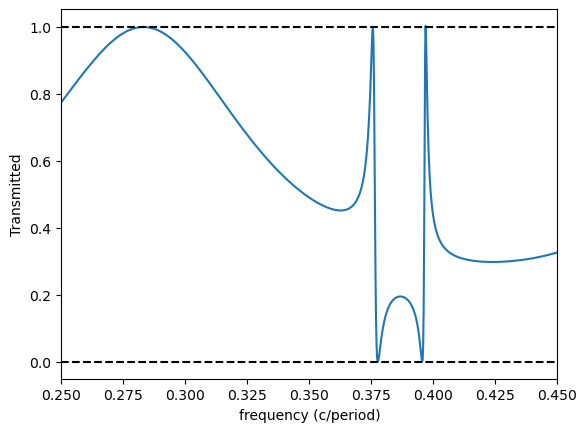

In [14]:
plt.figure()
plt.plot(monitor_freqs*period/td.C_0, transmission_normalized, label='normalized transmission')
plt.xlabel('frequency (c/period)')
plt.xlim([0.25, 0.45])
plt.hlines(1.0,0.25,0.45,linestyles='dashed',color='black')
plt.hlines(0.0,0.25,0.45,linestyles='dashed',color='black')
plt.ylabel('Transmitted')
plt.show()

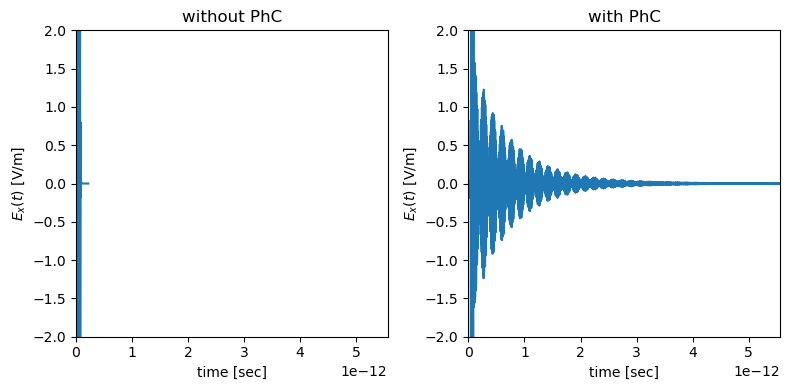

In [15]:
time_data = sim_data['time']
time_data0 = sim_data0['time']
fig, ax = plt.subplots(1,2,figsize=(8, 4), tight_layout=True)
ylim = 2
xlim = t_stop
# with PhC
Ex = time_data.Ex
Ex.plot(ax=ax[1])
ax[1].set_ylim([-ylim,ylim])
ax[1].set_xlim([0,xlim])
ax[1].set_ylabel('$E_x(t)$ [V/m]')
ax[1].set_title('with PhC')
# without PhC
Ex0 = time_data0.Ex
Ex0.plot(ax=ax[0])
ax[0].set_ylabel('$E_x(t)$ [V/m]')
ax[0].set_xlim([0,xlim])
ax[0].set_ylim([-ylim,ylim])
ax[0].set_title('without PhC')

plt.show()